## Final Capstone: Text Classification of Wine Reviews with NLP
by Doug Johnson

#### Problem trying to address:  
Generation Z isn’t drinking wine at the same growth rate as prior generations. As a result the wine industry is experiencing a demand shortage during a time where quantity of grapes in cultivation has increased. Price pressure is forecasted due to these circumstances, in certain segments. Without an increase in demand, or reducing grape acreage under cultivation, the wine industry could see a reduction in profit margins. Surveys show Generation Z finds the wine market hard to understand and wants online advertising, online education, and an online application to help navigate product.   

#### Project Statement:   
Create application which can identify quality of a wine based on text reviews using NLP to:    
* Suggest wines similar to flavor preferences.  
* Suggest varietals similar to known preferred varietal. 
* Suggest different varietals with similar ratings in similar region.
* Suggest wines that appear to be values, or if desired, best-of-breed or prestigious.  

#### Run as slide show. Navigate to directory:  

https://github.com/DougJ/Public/blob/master/Final%20Capstone.ipynb  
https://github.com/DougJ/Public/blob/master/Final_Capstone.ipynb

jupyter nbconvert --to slides C:\Users\DJ\Documents\AnacondaPython\Thinkful\Final_Capstone\Final_Capstone.ipynb

#### Data Source 

Source:  https://www.kaggle.com/zynicide/wine-reviews  

The data was scraped from Wine Enthusiast during the week of June 15th, 2017.  
Shape(129971, 14)   
Rows (129971) Ratings/reviews OF wine. Sometimes same wine, different reviewer.  
Features (14)   

#### Features

Country - The country that the wine is from (ex. “France”)  
Description – text reviews (“best of wines, worst of wines”)  
Designation - The vineyard within the winery where the grapes that made the wine are from (ex. “Reserve”). Similar to title.  
Points - The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for (ex. 90)  
Price - The cost for a bottle of the wine (ex. $15)  
Province - The province or state that the wine is from (ex. “California”)   
Region 1 - The wine growing area in a province or state (ex “Napa Valley”)  
Region 2 - Sometimes there are more specific regions specified within a wine growing area (ie “Rutherford” inside the “Napa Valley”)  
Taster Name – (ex. “Roger Voss”)  
Taster Twitter Handle – (ex. “@vossroger”)  
Title - The title of the wine review, which often contains the vintage (ex. “Nicosia 2013 Vulkà Bianco (Etna)”)   
Variety – The type of grapes used to make the wine (ex. “Pinot Noir”)  
Winery – The winery that made the wine (ex. “Quinta dos Avidagos”)  

#### Feature of primary interest: 'description'.

NLP - Will utilize the 'description' feature which is a review for a given wine. Using the text from the review, will use TF-IDF and Word2Vec in both supervised and unsupervised learning, including topic extraction. 

#### Target Variable
point_rank:   
> categorical: '0','1'   
0 -> Premium Super Segment   
1 -> Luxury  Super Segment  

#### Milestones:
Step 1: Load data.  
Step 2: Clean data.  
Step 3: Explore data. Price and numeric rating first, then the text review('description').  
Step 4: NLP, TF-IDF and Word2Vec including topic modeling.  
Step 5: Test classification prediction using text and numeric features with multiple models.  
Step 6: Application prototype.   
Step 7: Summary.

In [1]:
import pandas as pd
import numpy as np

import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
%matplotlib inline

# NLP
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
stemmer = SnowballStemmer("english")
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
import spacy
import gensim
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# DIMENSION REDUCTION AND CLUSTERING
from sklearn.decomposition import PCA, NMF, LatentDirichletAllocation as LDA, TruncatedSVD # Dimensional Reduction
from sklearn.cluster import KMeans
import umap
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors # KNN Clustering 
from scipy.sparse import csr_matrix # Compressed Sparse Row matrix

# MODELS
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing, ensemble
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler, PowerTransformer # Yeo-Johnson or Boxcox

# MODEL SELECTION
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

# METRICS AND REPORTING
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity

# PIPELINE
from sklearn.pipeline import Pipeline, make_pipeline

import time
import itertools

## Step 1: Load the data

#### Aggregate data files to get more wine reviews. 

In [2]:
# LOAD FILE FROM CSV PUT INTO ONE DATAFRAME
wine_130k = pd.read_csv(("../FilesToLoad/wine-reviews/winemag-data-130k-v2.csv"))
wine_150k = pd.read_csv(("../FilesToLoad/wine-reviews/winemag-data_first150k.csv"))
df = pd.concat([wine_150k, wine_130k],axis=0, sort=False)
#wine = wine_150k
print("Number of rows and columns:",df.shape)

Number of rows and columns: (280901, 14)


In [3]:
# (COLUMNS, ROWS) IN CONATENATED DATAFRAME
df.shape

(280901, 14)

In [4]:
# CHECK THAT DATA TYPES APPEAR TO BE CORRECT, AND LOOK AT COUNTS
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280901 entries, 0 to 129970
Data columns (total 14 columns):
Unnamed: 0               280901 non-null int64
country                  280833 non-null object
description              280901 non-null object
designation              197701 non-null object
points                   280901 non-null int64
price                    258210 non-null float64
province                 280833 non-null object
region_1                 234594 non-null object
region_2                 111464 non-null object
variety                  280900 non-null object
winery                   280901 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 32.1+ MB


## Step 2: Clean Data

#### Duplicates exist in description, remove.

In [5]:
# DUPLICATE COUNTS (ROWS, COLUMNS)
print("Row level duplicates:   {}".format(df[df.duplicated()].shape))
print("Description duplicates: {}".format(df[df.duplicated('description')].shape))

Row level duplicates:   (0, 14)
Description duplicates: (111471, 14)


In [6]:
# DROP DUPLICATES
df.drop_duplicates('description', keep='first', inplace=True)

# DROP 'Unnamed: 0' FROM DATAFRAME
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# NEW DATAFRAME SHAPE
print("Description duplicates: {}".format(df[df.duplicated('description')].shape))
print("Dataframe shape: {}".format(df.shape))

Description duplicates: (0, 13)
Dataframe shape: (169430, 13)


#### Primary columns are points, price and description, variety, winery, region_1, and country. Remove review rows where there are null values in a primary category.  

In [7]:
df.dropna(axis=0, subset=['country','price', 'variety'], inplace=True)

## Step 3: EDA, Preprocessing, and Feature Engineering

### Variable of significance
Each row contains a review and information for a bottle of wine. The review is named 'description'. 

Sample highest point rating review:  
2145    Full of ripe fruit, opulent and concentrated, this is a fabulous and impressive wine. It has a beautiful line of acidity balanced with ripe fruits. The wood aging is subtle, just a hint of smokiness and toast. This is one of those wines, from a great white wine vintage, that will age many years. Drink from 2024.  


In [8]:
pd.set_option('display.max_colwidth', -1)
print("Sample highest point rating review:")
print(df[df['points']==100]['description'].head(1))
print()
print("Sample mean point rating review:")
print(df[df['points']==90]['description'].head(1))
print()
print("Sample lowest point rating review:")
print(df[df['points']==80]['description'].head(1))

Sample highest point rating review:
2145    Full of ripe fruit, opulent and concentrated, this is a fabulous and impressive wine. It has a beautiful line of acidity balanced with ripe fruits. The wood aging is subtle, just a hint of smokiness and toast. This is one of those wines, from a great white wine vintage, that will age many years. Drink from 2024.
Name: description, dtype: object

Sample mean point rating review:
30    This Bulgarian Mavrud presents the nose with suggestions of dried cherry, black plum, freshly ground black pepper and a whiff of eucalyptus. In the mouth it is balanced with soft tannins mingling with dried cherry, cassis and black plum.
Name: description, dtype: object

Sample lowest point rating review:
7793    Tropical, soapy aromas are yeasty and flat. Flavors of lychee and melon have no follow-through and finish mealy.
Name: description, dtype: object


#### Majority of wineries with reviews in this dataset are in US, France and Italy. California is the primary producer in the U.S. and pinot noir is the most reviewed grape.

In [9]:
df[df['province']=='California']['variety'].value_counts().head(10)

Pinot Noir                  8828
Cabernet Sauvignon          7873
Chardonnay                  6899
Zinfandel                   3691
Syrah                       2668
Sauvignon Blanc             2473
Red Blend                   2213
Merlot                      2155
Bordeaux-style Red Blend    1194
Petite Sirah                914 
Name: variety, dtype: int64

#### This project will use pinot noir reviews from the top 20 most reviewed regions in California.

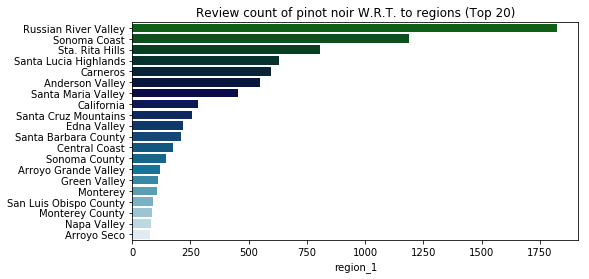

In [10]:
# 20 MOST REVIEWED REGIONS FOR PINOT NOIR IN CA
plt.figure(figsize=(8,4))
cnt = df[(df['country'] == 'US') & 
         (df['province'] =='California') & 
         (df['variety'] == 'Pinot Noir')]['region_1'].value_counts().to_frame()[0:20]
sns.barplot(x= cnt['region_1'], y =cnt.index, data=cnt, palette='ocean',orient='h')
plt.title('Review count of pinot noir W.R.T. to regions (Top 20)');

#### Create dataframe for the top 20 pinot noir production regions based on review count. 

Note there is a bias in this dataset to Russian River Valley and the Sonoma Coast as they are have significantly more reviews than the majority of other regions.  This should not impact project and is more a statement on the primary regions for Premium and Luxury pinot noir production.  

In [11]:
pn_region_list = ['Russian River Valley', 'Sonoma Coast', 'Sta. Rita Hills',
       'Santa Lucia Highlands', 'Carneros', 'Anderson Valley',
       'Santa Maria Valley', 'California', 'Santa Cruz Mountains',
       'Edna Valley', 'Santa Barbara County', 'Central Coast', 'Sonoma County',
       'Arroyo Grande Valley', 'Green Valley', 'Monterey',
       'San Luis Obispo County', 'Monterey County', 'Napa Valley',
       'Arroyo Seco']

df_pn20_prc = df[(df['country'] == 'US') & 
                 (df['province'] =='California') & 
                 (df['variety'] == 'Pinot Noir') &
                 (df['region_1'].isin(pn_region_list))].copy()

#### Create a new index so can merge dataframes later.

In [12]:
df_pn20_prc.reset_index();
df_pn20_prc.insert(0, 'rating_ID', range(0, len(df_pn20_prc)))

### Univariate Analysis

In [13]:
# .T TRANSPOSES DATAFRAME
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,156552,48,US,70491,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,156552,156552,"The '04 Maiden is very close to Harlan Estate in quality. The Maiden is a touch less elegant; but it is such a wholesome wine, so succulent in blackberry, cassis, licorice, and roasted cedar. The tannins are so regal—even the slight prickle of acidity works for polish. So beautiful now, it's hard to know when to suggest drinking it, but this should easily be a 10–15 year wine.",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
designation,110034,44351,Reserve,2802,NaN,NaN,NaN,NaN,NaN,NaN,NaN
points,156552,NaN,NaN,NaN,88.1924,3.15024,80,86,88,90,100
price,156552,NaN,NaN,NaN,34.6458,39.3853,4,16,25,40,3300
province,156552,483,California,48458,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_1,130976,1307,Napa Valley,6401,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region_2,67184,18,Central Coast,14504,NaN,NaN,NaN,NaN,NaN,NaN,NaN
variety,156552,739,Pinot Noir,15983,NaN,NaN,NaN,NaN,NaN,NaN,NaN
winery,156552,18143,Williams Selyem,299,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Price outlier with boxplot
Although there is a wide range of prices, the outliers are legitimate price observations. Certain wineries command a premium due to quality, scarcity, and prestige. The observations are based on price per 750ml.

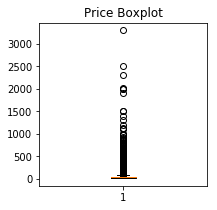

In [14]:
# BOXPLOT
plt.figure(figsize=(3,3))
plt.boxplot(df['price'],whis=1.5)
plt.title('Price Boxplot')
plt.show()

#### Price - Distribution

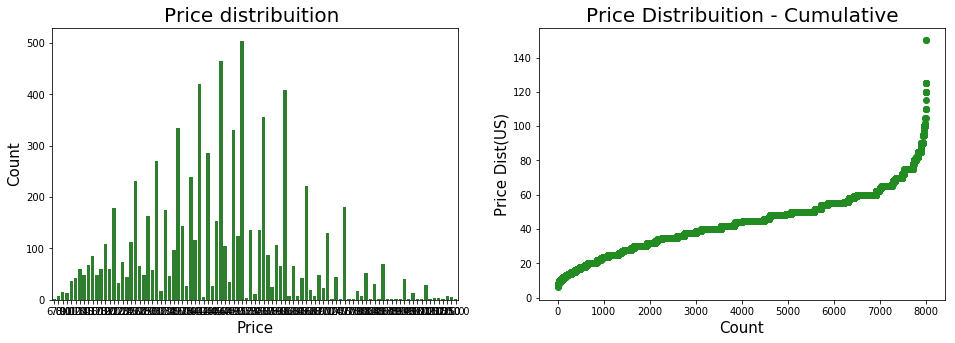

In [15]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1) 
prc = sns.countplot(x='price', data=df_pn20_prc, color='forestgreen') 
prc.set_title("Price distribuition ", fontsize=20) 
prc.set_xlabel("Price", fontsize=15)
prc.set_ylabel("Count", fontsize=15)

plt.subplot(1,2,2)
plt.scatter(range(df_pn20_prc.shape[0]), np.sort(df_pn20_prc.price.values), color='forestgreen') # creating a cumulative distribution
plt.xlabel('Count', fontsize=15)
plt.ylabel('Price Dist(US)', fontsize=15) 
plt.title("Price Distribuition - Cumulative", fontsize=20)
plt.show() #rendering the graphs

#### Rating ("points") outlier with boxplot
>Majority of ratings rank the wines between 86 and 90 points where greater than 90 points appears to be a designation for an above average wine, and less than 86 for a below average wine.

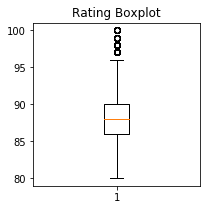

In [16]:
# BOXPLOT
plt.figure(figsize=(3,3))
plt.boxplot(df['points'],whis=1.5)
plt.title('Rating Boxplot')
plt.show()

#### Point Distribution

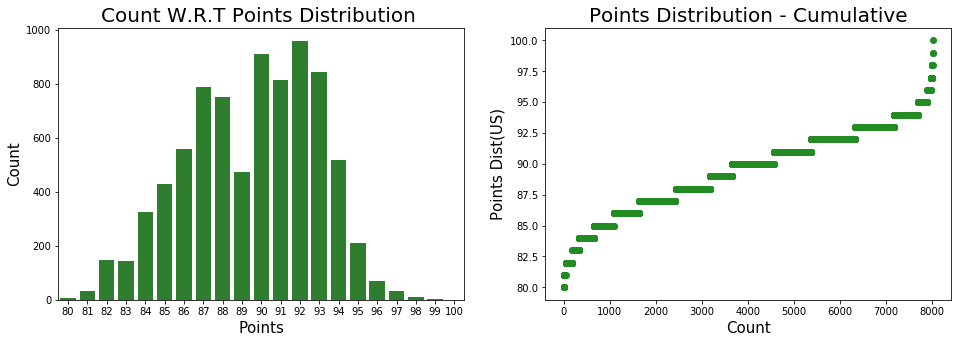

In [17]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
g = sns.countplot(x='points', data=df_pn20_prc, color='forestgreen') 
g.set_title("Count W.R.T Points Distribution ", fontsize=20)
g.set_xlabel("Points", fontsize=15)
g.set_ylabel("Count", fontsize=15)

plt.subplot(1,2,2)
plt.scatter(range(df_pn20_prc.shape[0]), np.sort(df_pn20_prc.points.values), color='forestgreen') # creating a cumulative distribution
plt.xlabel('Count', fontsize=15)
plt.ylabel('Points Dist(US)', fontsize=15)
plt.title("Points Distribution - Cumulative", fontsize=20)

plt.show()

#### Classify rating W.R.T. length of text wine review
Appears there is a relationship between a long review and a high rating score. 

In [18]:
# PUT LENGTH FEATURE INTO PRICE AND RATING DATAFRAMES
df_pn20_prc = df_pn20_prc.assign(desc_length = df_pn20_prc['description'].apply(len))

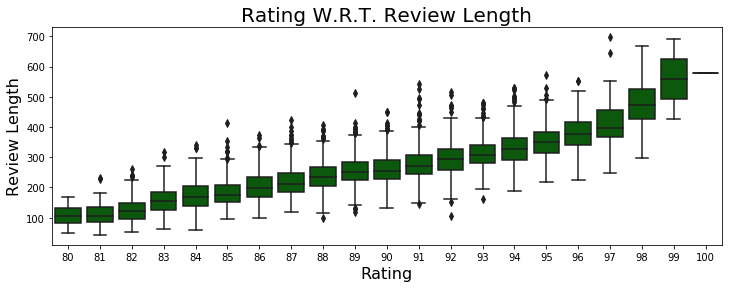

In [19]:
plt.figure(figsize=(12,4))
prc_bp = sns.boxplot(x='points', y='desc_length', data=df_pn20_prc,
                color='darkgreen')
prc_bp.set_title('Rating W.R.T. Review Length', fontsize=20)
prc_bp.set_ylabel('Review Length', fontsize = 16) # Y label
prc_bp.set_xlabel('Rating', fontsize = 16) # X label
plt.show()

### Bivariate Analysis

#### Price by region

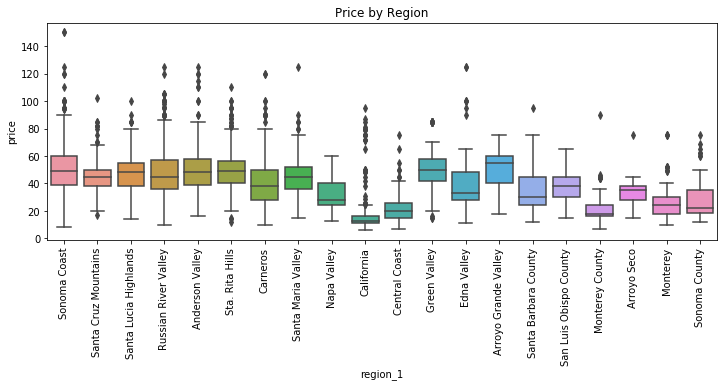

In [20]:
plt.figure(figsize=(12,4))
sns.boxplot(x=df_pn20_prc['region_1'], y=df_pn20_prc['price'])
plt.title('Price by Region')
plt.xticks(rotation=90);

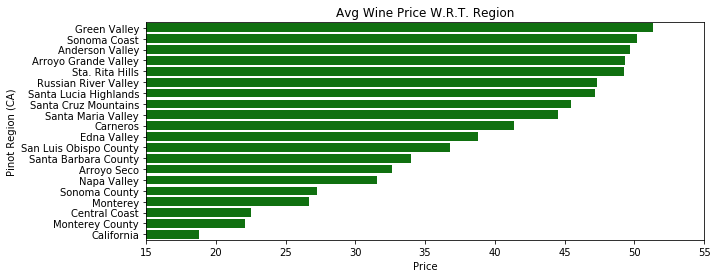

In [21]:
cnt = df_pn20_prc.groupby(['region_1']).mean()['price'].sort_values(ascending=False).to_frame()[0:20]
fig,ax = plt.subplots(figsize=(10,4))
sns.barplot(x= cnt['price'], y=cnt.index, data=cnt, color='green', orient='h')#palette='ocean',)
ax.set(xlim=(15, 55))
ax.set(title='Avg Wine Price W.R.T. Region')
ax.set(xlabel='Price')
ax.set(ylabel='Pinot Region (CA)');

#### Rating by Region

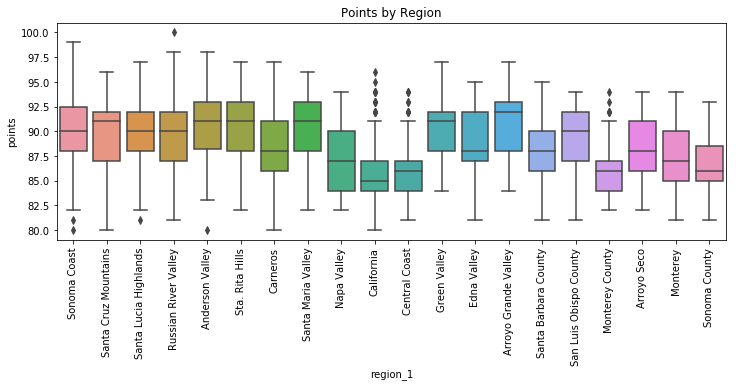

In [22]:
plt.figure(figsize=(12,4))
sns.boxplot(x=df_pn20_prc['region_1'], y=df_pn20_prc['points'])
plt.title('Points by Region')
plt.xticks(rotation=90);

#### Point rating density: Two histograms, one 90 and below, the other 91 and above

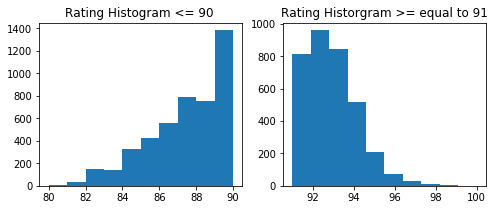

In [23]:
plt.figure(figsize=(8,3))

plt.subplot(1, 2, 1)
plt.hist(df_pn20_prc[df_pn20_prc['points']<=90]['points'])
plt.title("{}".format('Rating Histogram <= 90 ')) 

plt.subplot(1, 2, 2)
plt.hist(df_pn20_prc[df_pn20_prc['points']>=91]['points'])
plt.title("{}".format('Rating Historgram >= equal to 91'))   

plt.show();

#### Analysis
Average price by region has a large difference from highest price to lowest price.  
The range of price is larger than the range of rating, as price has no upper boundary and rating boundary is fixed with lower boundary = 80, upper boundary 100. 

The ratings will ultimately be grouped and become the classification target. 

Price appears to have variance and value as a feature.  

#### Price and point rating analysis

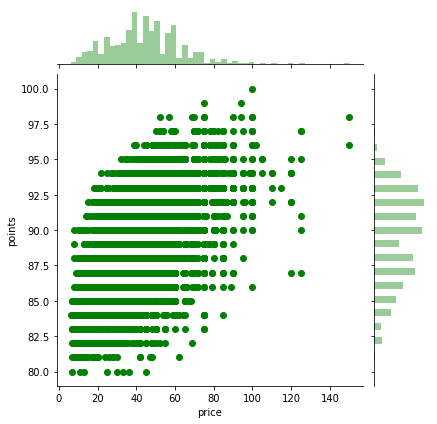

In [24]:
sns.jointplot(x=df_pn20_prc['price'], y=df_pn20_prc['points'], color='g');

### One Hot Encoding
Regions appear to have an impact on point ratings. Create binary features for each region for use later. 

In [25]:
one_hot_list_all = []
cat_list = ['region_1']

for feature in cat_list:
    df_pn20_prc = pd.concat([df_pn20_prc, pd.get_dummies(df_pn20_prc[feature], prefix=feature, 
                                                         drop_first=False)], axis=1)
    one_hot_list_all.extend(list(pd.get_dummies(df_pn20_prc[feature], prefix=feature, 
                                                drop_first=True).columns))
    df_pn20_prc.drop(feature, axis=1, inplace=False) 

In [26]:
print(df_pn20_prc.shape)
print(df_pn20_prc.columns)
#df_pn20_prc.head(3)

(8013, 35)
Index(['rating_ID', 'country', 'description', 'designation', 'points', 'price',
       'province', 'region_1', 'region_2', 'variety', 'winery', 'taster_name',
       'taster_twitter_handle', 'title', 'desc_length',
       'region_1_Anderson Valley', 'region_1_Arroyo Grande Valley',
       'region_1_Arroyo Seco', 'region_1_California', 'region_1_Carneros',
       'region_1_Central Coast', 'region_1_Edna Valley',
       'region_1_Green Valley', 'region_1_Monterey',
       'region_1_Monterey County', 'region_1_Napa Valley',
       'region_1_Russian River Valley', 'region_1_San Luis Obispo County',
       'region_1_Santa Barbara County', 'region_1_Santa Cruz Mountains',
       'region_1_Santa Lucia Highlands', 'region_1_Santa Maria Valley',
       'region_1_Sonoma Coast', 'region_1_Sonoma County',
       'region_1_Sta. Rita Hills'],
      dtype='object')


### Wine market segmentation
Generally speaking the wine market is broken up into segments based on price. There are certainly customer demographics that are important to the wine industry, but for this project we don't have access to that data.  

Price segmentation.  

Some have grouped the wine market into three general categories (super segments). Note this is for all varietals.  These segments are:  
* Everyday (in an efficient market, lower price, lower rating)  
* Premium  
* Luxury   (in an efficient market, higher price, higher rating)  
 
This project chose two categories to classify, premium and luxury.  
* 0: Premium  
* 1: Luxury   in an efficient market, higher price, higher rating)

Here is the reasoning. Pinot noir has a thin skin, and the yield per acre, particularly for high end pinot (drop fruit for concentration), is significantly lower than, Cabernet Sauvignon for example. Moreover pinot is more susceptiable to adverse weather variables such as temperature and moisture. This increases cost of production. For the most part, pinot noir has a higher cost of production and thus not used as frequently for mass market bottlings at an "everyday" price point (think box wines and bottles < $7). Certainly there are lower price point pinot's, but on the whole, pinot, particularly in the reviews in this dataset (bias will be addressed in summary), is not frequently reviewed, in the "everyday" segment.  

To conclude, two super segment categories will be used to classify the pinot reviews as actual point predictions would be nuanced, possibly overfitted, and likely not generalize well.

#### Target variable
As review observations appear to group well into two segments and we will assign two classification targets:    
0: Premium which is 90 points and below.    
1: Luxury which is 91 points and above. 

Values in each category:  
>0: Premium = 4560  
1: Luxury = 3453  

In [27]:
# RANK
df_pn20_prc['point_rank']=pd.qcut(df_pn20_prc['points'],2,labels=False)
df_pn20_prc['point_rank'].value_counts()

0    4560
1    3453
Name: point_rank, dtype: int64

### Standardize features
Prior to clustering with UMAP will standardize our features and apply to dataframe with new names. 

In [28]:
pt = PowerTransformer(standardize=True, copy=False, method ='box-cox')
df_trans = pt.fit_transform(df_pn20_prc[['price', 'desc_length']])
df_trans = pd.DataFrame(df_trans, columns=['prc_bc', 'desc_len_bc'])

In [29]:
df_trans.insert(0, 'rating_ID', range(0, len(df_trans)))
df_pn20_prc = df_pn20_prc.merge(df_trans, on='rating_ID', how='left')

### Numeric correlation between point rating, price, and description length features.

In [30]:
# NUMERIC CORRELATION BETWEEN POINTS AND STANDARDIZED PRICE AND DESCRIPTION LENGTH
corr=df_pn20_prc[['points','prc_bc','desc_len_bc']].corr()
corr.style.background_gradient(cmap = 'coolwarm')

,points,prc_bc,desc_len_bc
points,1,0.577789,0.73926
prc_bc,0.577789,1,0.45348
desc_len_bc,0.73926,0.45348,1


#### Analysis
Description length has a high correlation with points, but medium correlation with price. 

### Visualization with dimension reduction and clustering
Visualize point ranking with respect to (W.R.T.) description length. Significance is to use unstructured learning to visualize clusters and perhaps best number of classifier categories. Since using NLP primarily, will focus on a basic engineered feature description length. 

#### UMAP: Visualization through dimension reduction

C:\Users\DJ\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


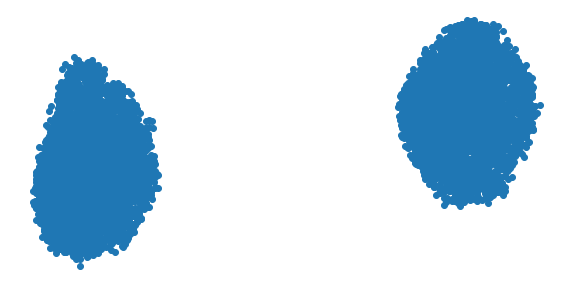

In [31]:
# UMAP
X = df_pn20_prc[['desc_len_bc', 'prc_bc']]
X.values

umap_results = umap.UMAP(n_neighbors=20, min_dist=1,
                         metric='correlation').fit_transform(X)

plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

#### KMeans Clustering - Elbow method 

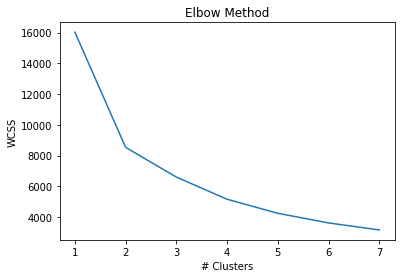

In [32]:
# DETERMINE OPTIMAL CLUSTER NUMBER 
# ELBOW METHOD -> WITHIN CLUSTER SUM OF SQUARES (WCSS)
wcss = []
for i in range(1,8):
    kmeans = KMeans(n_clusters = i, init = 'random', max_iter = 300,
                    n_init = 10, random_state = 42)
    kmeans.fit(df_pn20_prc[['desc_len_bc','prc_bc']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1,8), wcss)
plt.title('Elbow Method')
plt.xlabel('# Clusters')
plt.ylabel('WCSS')
plt.show()

#### Agglomerative Clustering with dendrogram, 'ward' method

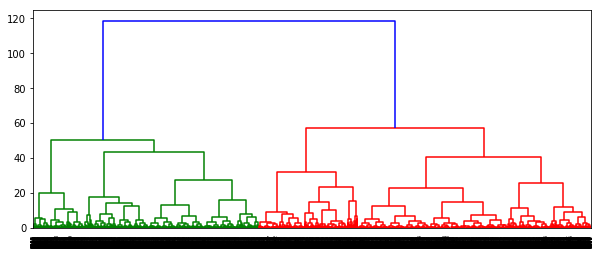

In [33]:
# AGGLOMERATIVE CLUSTERING
plt.figure(figsize=(10,4))
dendrogram(linkage(df_pn20_prc[['desc_len_bc','prc_bc']], method='ward'))
plt.show()

#### Clustering analysis
UMAP not showing seperation.  
KMEANS elbow method places optimal cluster number at two.  
Agglomerative clustering shows two distinct clusters.  

Appears that the choice of two target categories to classify is reasonable according to clustering methods W.R.T. description length.

#### Benchmark price and description length 
Predict whether premium or luxury based on only price and description length.  

In [34]:
X = df_pn20_prc[['prc_bc','desc_len_bc']]
y = df_pn20_prc['point_rank']

In [35]:
logreg = LogisticRegression(solver='lbfgs',max_iter=50000, multi_class='auto')
score_fs = cross_val_score(logreg, X, y, scoring="accuracy", cv=3)   
print("mean={:.2f}   std=(+/- {:.2f})   all={} ".format(score_fs.mean(),
                                                        score_fs.std()*2, score_fs))

mean=0.80   std=(+/- 0.02)   all=[0.80456758 0.80643954 0.77948334] 


#### Benchmark regions
Predict whether premium or luxury based on only regions.

In [36]:
df_pn20_prc.iloc[:,15:35].columns

Index(['region_1_Anderson Valley', 'region_1_Arroyo Grande Valley',
       'region_1_Arroyo Seco', 'region_1_California', 'region_1_Carneros',
       'region_1_Central Coast', 'region_1_Edna Valley',
       'region_1_Green Valley', 'region_1_Monterey',
       'region_1_Monterey County', 'region_1_Napa Valley',
       'region_1_Russian River Valley', 'region_1_San Luis Obispo County',
       'region_1_Santa Barbara County', 'region_1_Santa Cruz Mountains',
       'region_1_Santa Lucia Highlands', 'region_1_Santa Maria Valley',
       'region_1_Sonoma Coast', 'region_1_Sonoma County',
       'region_1_Sta. Rita Hills'],
      dtype='object')

In [37]:
X = df_pn20_prc.iloc[:,15:35]
y = df_pn20_prc['point_rank']

In [38]:
logreg = LogisticRegression(solver='lbfgs',max_iter=50000, multi_class='auto')
score_fs = cross_val_score(logreg, X, y, scoring="accuracy", cv=3)   
print("mean={:.2f}   std=(+/- {:.2f})   all={} ".format(score_fs.mean(),
                                                        score_fs.std()*2, score_fs))

mean=0.61   std=(+/- 0.03)   all=[0.58554848 0.60913516 0.62560839] 


#### Benchmark price, description length and regions

In [39]:
X = df_pn20_prc.iloc[:,15:].drop(columns='point_rank', axis=1)
y = df_pn20_prc['point_rank']

In [40]:
logreg = LogisticRegression(solver='lbfgs',max_iter=50000, multi_class='auto')
score_fs = cross_val_score(logreg, X, y, scoring="accuracy", cv=3)   
print("mean={:.2f}   std=(+/- {:.2f})   all={} ".format(score_fs.mean(),
                                                        score_fs.std()*2, score_fs))

mean=0.80   std=(+/- 0.03)   all=[0.80718832 0.81505054 0.7768626 ] 


#### Analysis
Appears price and description length hold most of the predictive power.

##### Price and description length: 80%  
mean=0.80   std=(+/- 0.02)   all=[0.80456758 0.80643954 0.77948334]   

##### Regions: 61%  
mean=0.61   std=(+/- 0.03)   all=[0.58554848 0.60913516 0.62560839]

##### Price, description length and regions: 80%  
mean=0.80   std=(+/- 0.03)   all=[0.80718832 0.81505054 0.7768626 ] 


## Step 4: NLP, TF-IDF and Word2Vec including topic modeling.

#### Create a stopwords variable and preprocess.   
Adding a custom list of stopwords to use in conjunction with the default 'STOPWORDS' from Genism. Results of custom list were better than default. Did initial benchmark tests to determine which method performed better. 

#### Preprocessing functions: Lemmantize and stem 

Lemmantize         -> Intended part of speech (POS) for meaning of word in sentence  
Stemming           -> Reduce word to root form   
Standardize tense  -> Verb tenses to present, third and second person to first person  
Punctuation        -> Remove all   
Lower case         -> Words to lower case  
Tokenize           -> Split review to process on a word level  
Character filter   -> Ignore small words, words < three characters ignored  
Stopwords          -> Ignore common words that are frequent and perceived as low value  

In [41]:
print(len(STOPWORDS))
stopwords = set(STOPWORDS)
newStopWords = ['fruit', "drink", "black", 'wine', "pinot", "noir", "palate", "flavor", "note",
                'russian', 'river', 'valley', 'sonoma', 'coast', 'sta', 'santa', 'rita', 'hills',
                'lucia', 'highlands', 'carneros', 'anderson', 'maria','california', 'santa', 
                'cruz', 'mountains','edna', 'barbara', 'central', 'coast', 'sonoma','county', 
                'arroyo', 'grande Valley', 'monterey', 'san', 'luis', 'obispo', 'monterey', 
                'napa', 'arroyo', 'seco', 'price','point','variety','accent', 'acid', 'add', 
                'alcohol', 'allspic', 'alongsid', 'anis', 'aroma', 
                'aromat', 'asian', 'bacon', 'bake', 'barrel',  'beef', 'beer', 'begin', 
                'berri',  'blackberri', 'blend', 'block', 'blueberri', 'bold', 'bone', 
                'bottl', 'boysenberri', 'brighten', 'bring', 'brisk', 'butter', 'caramel', 
                'cardamom', 'carri', 'case', 'cedar', 'cellar', 'charact', 'cherri', 'chocol',
                'cinnamon', 'climat', 'clone', 'coat', 'cocoa', 'coffe', 'cola', 'color', 
                'combin', 'come', 'cool', 'core', 'cranberri', 'crush', 'currant', 'dark', 
                'defin', 'deliv', 'design', 'despit', 'develop', 'dimension', 'direct', 
                'domin', 'dri', 'drink', 'drinkabl', 'drive', 'dryness',  'easi', 
                'element', 'emerg', 'especi', 'estat', 'eucalyptu', 'experi', 'express', 
                'extract', 'fairli', 'famili', 'fennel', 'flavor', 'focu', 'follow', 
                'food', 'forest', 'frame', 'fruit', 'fruiti', 'fulli', 'gener', 
                'glass', 'grape', 'graphit', 'grill', 'grow', 'hibiscu', 'hint', 'includ', 
                'juic', 'juici', 'junip', 'know', 'lace', 'lack', 'lamb', 'lavend', 'lead', 
                'leather', 'level', 'licoric', 'lift', 'light', 'lighter', 'lightli', 'like', 
                'littl', 'live', 'lot', 'make', 'mark', 'meat', 'meet', 'mellow', 'mocha', 
                'mulberri', 'near', 'need', 'noir', 'nose', 'note', 'nutmeg', 'offer', 'oliv', 
                'open', 'opul', 'orang', 'oregano', 'pack', 'pair', 'peel', 'pencil', 
                'pepper', 'peppercorn', 'pepperi', 'persimmon', 'pine', 'pinot', 'plant', 
                'plenti', 'plum', 'pomegran', 'produc', 'product', 'provid', 'purpl', 'rang', 
                'raspberri', 'readi', 'real', 'refin', 'region', 'releas', 'remain', 'result', 
                'rhubarb', 'right', 'rise', 'roast', 'root', 'round', 'rustic', 'sage', 
                'sagebrush', 'sandalwood', 'scent', 'select', 'singl', 'sit', 'site', 'skin', 
                'slightli', 'smell', 'smoke', 'smoki', 'somewhat', 'sourc', 'spice', 'spici', 
                'start', 'steak', 'strawberri', 'streak', 'style',  'support', 'tast', 'tasti', 
                'thyme', 'time', 'toast', 'toasti', 'tone', 'touch', 'turn', 
                'vanilla', 'variet', 'vineyard', 'vintag', 'violet', 'want', 'warm', 
                'weight', 'white', 'wild', 'win', 'wind', 'winemak', 'wineri', 'wonder', 
                'wrap', 'year']
stopwords.update(newStopWords)
print(len(stopwords))

337
590


In [42]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        #if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
        if token not in stopwords and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return " ".join(result)

In [43]:
# ITERATE OVER EACH 'description' AND THEN PREPROCESS AND STORE AS 'clean_desc'
df_pn20_prc['clean_desc'] = df_pn20_prc['description'].map(lambda x: preprocess(x))

#### Analyze impact of preprocessing on description.

In [44]:
#ANALYZE IMPACT OF PREPROCESSING
print(df_pn20_prc['description'].head(1))
print()
print(df_pn20_prc['clean_desc'].head(1))

0    The producer sources from two blocks of the vineyard for this wine—one at a high elevation, which contributes bright acidity. Crunchy cranberry, pomegranate and orange peel flavors surround silky, succulent layers of texture that present as fleshy fruit. That delicately lush flavor has considerable length.
Name: description, dtype: object

0    produc sourc block high elev contribut bright acid crunchi cranberri pomegran orang flavor surround silki succul layer textur present fleshi delic lush consider length
Name: clean_desc, dtype: object


(-0.5, 399.5, 199.5, -0.5)

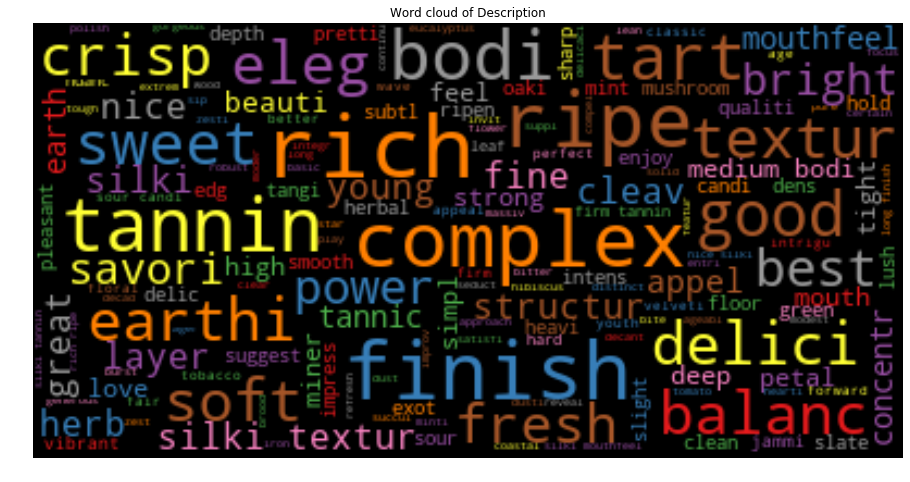

In [45]:
plt.figure(figsize= (16,8))
plt.title('Word cloud of Description')
wc = WordCloud(max_words=1000,max_font_size=40,
               background_color='black', 
               stopwords = stopwords, 
               #stopwords = STOPWORDS, 
               colormap='Set1')
wc.generate(' '.join(df_pn20_prc['clean_desc']))
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')

#### Analysis
The preprocessing has done a good job of removing common words. But it appears there are common words unique to wine reviews that look to not add value such as "pinot noir" and "flavor".

#### TF-IDF

* ngram = 1, meaning no bi-grams or tri-grams, ie multiple words as one feature such as "pinot noir" or "cherry cola". 
* Word level
* minimum document frequency of .01.

Term Frequence = Number times document appears in a documents.
Inverse Document Frequence = log((total number of documents)/(number documents with term))

TF-IDF = TF x IDF

In [46]:
tfidf_vect_ngram = TfidfVectorizer(
    #max_df=0.1,  # above max document frequency ignore word
    min_df=0.01,  # below min document frequency ignore word
    analyzer='word', 
    token_pattern=r'\w{1,}', 
    ngram_range=(1,1), 
    max_features=5000,
    #stop_words='english', 
    stop_words=stopwords, 
    lowercase=False,
    vocabulary=None)

# FIT ON ALL DOCUMENTS
tfidf_ngram = tfidf_vect_ngram.fit_transform(df_pn20_prc['clean_desc'])
tfidf_ngram_feat = tfidf_vect_ngram.get_feature_names()

C:\Users\DJ\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['Valley', 'grande'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [47]:
print(type(tfidf_ngram))
print(type(tfidf_ngram_feat))
print(df_pn20_prc.shape)
print(tfidf_ngram.shape)

<class 'scipy.sparse.csr.csr_matrix'>
<class 'list'>
(8013, 39)
(8013, 155)


#### Convert matrix to dataframe. View TF-IDF scores.

In [48]:
# USE THIS TO GET tfidf_ngram INTO DATAFRAME VS CSR MATRIX
# GO FROM SPARSE TO DENSE. SPARSE IS OPTIMIZED MATRIX FOR LOOKUP. 
dense = tfidf_ngram.todense()
denselist = dense.tolist()

# CONVERT LIST TO DATAFRAME, RENAME
df_tfidf_ngram_wine = pd.DataFrame(denselist, columns=tfidf_ngram_feat)
df_tfidf_ngram_wine.head(1)

,age,ageabl,ager,appeal,appel,approach,balanc,beauti,best,better,...,tough,unrip,veget,velveti,vibrant,wave,young,youth,zest,zesti
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Merge two dataframes by index

In [49]:
df_pn20_prc = pd.merge(df_pn20_prc, df_tfidf_ngram_wine, left_index=True, right_index=True);

#### PCA: Reduce featues and benchmark TF-IDF scores

In [50]:
df_pn20_prc.iloc[:,39:].columns

Index(['age', 'ageabl', 'ager', 'appeal', 'appel', 'approach', 'balanc',
       'beauti', 'best', 'better',
       ...
       'tough', 'unrip', 'veget', 'velveti', 'vibrant', 'wave', 'young',
       'youth', 'zest', 'zesti'],
      dtype='object', length=155)

In [51]:
X = df_pn20_prc.iloc[:,39:]
y = df_pn20_prc['point_rank']

In [52]:
# SET PCA ABOVE 80% VARIANCE EXPLAINED, HOWEVER MANY COMPONENTS
selector = PCA(n_components=.80).fit(X,y)
# SELECT # COMPONENTS
#selector = PCA(n_components=10).fit(X,y)
var_explained = selector.explained_variance_ratio_ 
var_explained = pd.Series(var_explained)
#print(round(var_explained,4))

In [53]:
pca = PCA(n_components = 90)
logreg = LogisticRegression(solver='lbfgs',max_iter=50000)
pipeline = Pipeline([('pca', pca), ('logistic', logreg)])
score_fs_pca = cross_val_score(pipeline, X, y, scoring="accuracy", cv=3)   
print("mean={:.2f}   std=(+/- {:.2f})   all={} ".format(score_fs_pca.mean(),
                                                        score_fs_pca.std()*2, score_fs_pca))

mean=0.72   std=(+/- 0.08)   all=[0.72968925 0.76001498 0.66417072] 


#### Analysis:

PCA on TD-IDF word features only.  

Mean accuracy changes from run to run.

Defaut Genism STOPWORD TF-IDF  
229 NLP Principal Components to explain 80% of the dataset.  
mean=0.77   std=(+/- 0.06)   all=[0.7768626  0.80868589 0.72968925]   

Modified stopwords with Genism STOPWORD TF-IDF  
90 NLP Principal Components to explain 80% of the dataset.  
mean=0.80   std=(+/- 0.03)   all=[0.80756271 0.81467615 0.77723699]  

#### UMAP: Dimension reduction visualization of TF-IDF scores.

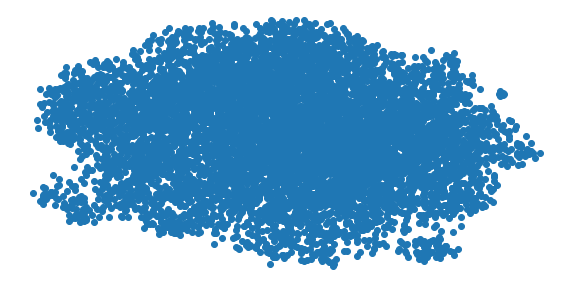

In [54]:
X = df_pn20_prc.iloc[:,39:]
X.values

umap_results = umap.UMAP(n_neighbors=20, min_dist=1,
                         metric='cosine').fit_transform(X)

plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

#### Clustering TF-IDF with KMeans

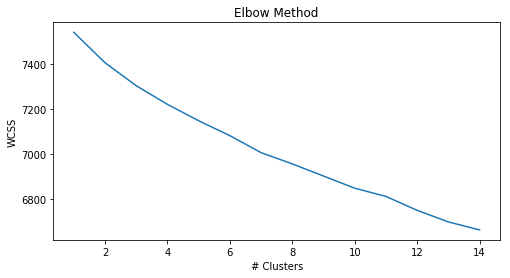

In [55]:
plt.figure(figsize= (8,4))

wcss = []
for i in range(1,15):
    kmeans = KMeans(n_clusters = i, init = 'random', max_iter = 300,
                    n_init = 10, random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15), wcss)
plt.title('Elbow Method')
plt.xlabel('# Clusters')
plt.ylabel('WCSS')
plt.show()

#### Clustering: TF-IDF with Agglomerative Clustering

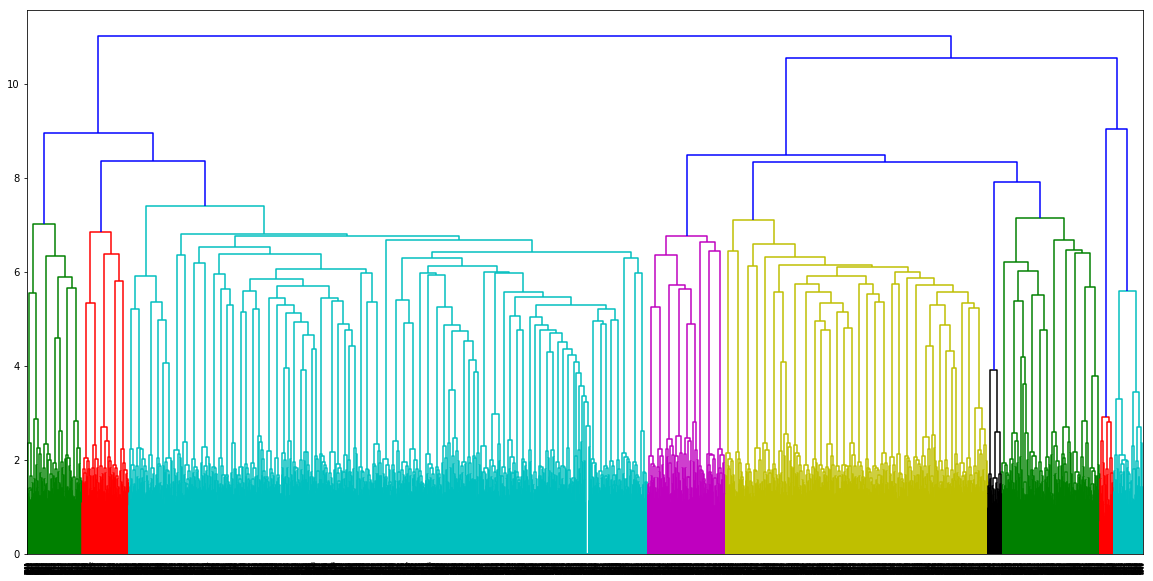

In [56]:
# AGGLOMERATIVE CLUSTERING
plt.figure(figsize=(20,10))
dendrogram(linkage(X, method='ward'))
plt.show()

# UNSTABLE CLUSTERING RESULT

#### Analysis:
UMAP: Showing two groups, one large blob, the other a small. Used cosine.  
K-Means: Steady decline, no leveling off. No conclusive result there, perhaps 1.  
Agglomorative Clusering: Two primary group. Doesn't clearly illustrate cluster number.  
    
Use two for topics, as UMAP and Agglomorative Clustering speak to one primary grouping and one small grouping. 

#### Topic modeling - TF-IDF scores with LSA, LDA and NNMF
2  Topics   10 Top Words    

LSA topic modeling. The core idea is to take a matrix of what we have — documents and terms — and decompose it into a separate document-topic matrix and a topic-term matrix. Can use TF or TF-IDF

SVD dimensionality reduction can be performed using truncated SVD. SVD, or singular value decomposition, is a technique in linear algebra that factorizes any matrix M into the product of 3 separate matrices: M=U*S*V, where S is a diagonal matrix of the singular values of M. Critically, truncated SVD reduces dimensionality by selecting only the t largest singular values, and only keeping the first t columns of U and V.

-LSA - large dataset required, don't know topics, components can be arbitraritly pos or neg  

PLSA is probabilistic versioin of LSA.  PLSA requires a fixed "document" in dataset. If don't have, can't predict.  A document that contains a topic will have a high probability of containing some words (related to the topic), and a low probability of containing other words (unrelated to the topic). Documents also have a probability of featuring each topic, low for some topics and high for others.

LDA Topic modeling. Baysian version of PLSA.  Looking at most probable distribution given existing distribution. Generalizes better than PLSA. Trains on set and can predict without using a specific document. 

NNMF - Non negative matrix factorization. Matrix multiplication with no negative numbers. Optimize using gradient descent. 

In [57]:
X = df_pn20_prc.iloc[:,39:]
y = df_pn20_prc['point_rank']

In [58]:
# LINK WORDS TO TOPICS
# NUMBER OF TOPICS
ntopics=2
# NUMBER OF WORDS TO LOOK IN EACH TOPIC
n_top_words = 20

In [59]:
def word_topic(tfidf, solution, wordlist):
    
    # SCORES BY WORD ON EACH TOPIC
    words_by_topic=tfidf.T * solution

    # LINKING WORDS FOR VIEWING
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# EXTRACT TOP WORDS FOR EACH TOPIC
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=[x for x in chosenlist]
    return(topwords)

In [60]:
# LSA
svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
wine_lsa = lsa.fit_transform(tfidf_ngram)

lsa_components = word_topic(tfidf_ngram, wine_lsa, tfidf_ngram_feat)

topwords=pd.DataFrame()
topwords['LSA']=top_words(lsa_components, n_top_words)  

In [61]:
# LDA
lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

lda_wine = lda.fit_transform(tfidf_ngram) 
lda_components = word_topic(tfidf_ngram, lda_wine, tfidf_ngram_feat)
topwords['LDA']=top_words(lda_components, n_top_words)

In [62]:
# NNMF
nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
nmf_wine = nmf.fit_transform(tfidf_ngram) 

nmf_components = word_topic(tfidf_ngram, nmf_wine, tfidf_ngram_feat)

topwords['NNMF']=top_words(nmf_components, n_top_words)

In [63]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic][0:40])

Topic 0:
               LSA              LDA            NNMF
0  rich 419.98      silki 321.6      rich 25.96    
0  tannin 380.32    rich 258.85      tannin 25.0   
0  silki 379.08     tannin 238.52    finish 24.48  
0  ripe 361.46      ripe 223.71      ripe 23.2     
0  finish 357.59    sweet 212.39     bodi 22.48    
0  complex 332.56   good 211.97      soft 16.66    
0  textur 330.4     complex 204.74   complex 16.64 
0  bodi 311.63      textur 204.0     sweet 15.97   
0  sweet 309.42     eleg 184.26      earthi 14.73  
0  soft 297.01      crisp 180.75     textur 13.94  
0  good 270.19      finish 175.03    balanc 13.49  
0  tart 254.58      tart 164.09      tart 12.96    
0  eleg 250.11      delici 156.0     delici 11.24  
0  crisp 232.14     bodi 150.52      structur 11.12
0  balanc 225.65    soft 147.84      fresh 10.86   
0  delici 224.93    fine 146.57      silki 10.44   
0  earthi 216.27    balanc 141.08    layer 9.32    
0  structur 198.01  nice 130.25      eleg 9.32     
0  

#### Analysis
Appears that LSA performed. Doesn't appear to have significant cluster difference between cluser 0 and 1.  Topic 0 appears to be luxury, and topic 1 appears to be premium.   

### Word2Vec

For a word W, it looks at the words that are near W in the sentence, and shifts the values in the word vectors such that the vectors for words near that W are closer to the W vector, and vectors for words not near W are farther away from the W vector. 

With a large enough corpus, this will eventually result in words that often appear together having vectors that are near one another, and words that rarely or never appear together having vectors that are far away from each other. 

Then, using the vectors, similarity scores can be computed for each pair of words by taking the cosine of the vectors.

In [64]:
# GET DATA IN PROPER FORMAT
df_w2v = df_pn20_prc['clean_desc']
df_w2v_clean = pd.DataFrame({'clean':df_w2v})
# LIST OF LIST
#sent1 = [row.split(',') for row in df_w2v_clean['clean']]
# LIST
sent = [row for row in df_w2v_clean['clean']]
sent[:2]

['produc sourc block high elev contribut bright acid crunchi cranberri pomegran orang flavor surround silki succul layer textur present fleshi delic lush consider length',
 'fresh live medium bodi beauti craft cherri blossom aroma tangi acid layer seduct offer crisp orang cherri pomegran bake flavor readi tabl']

In [65]:
tokenized_corpus = [nltk.word_tokenize(sentence) for sentence in sent]

In [66]:
model = gensim.models.Word2Vec (tokenized_corpus, 
                                size=150,     # SIZE OF DENSE VECTOR TO REPRESENT EACH WORD. 
                                              #MORE DATA LARGER, LESS DATA SMALLER. 
                                window=10,    # MAX DISTANCE BTW TARGET WORD AND NEIGHBOR.
                                min_count=2,  # MIN FREQUENCY COUNT OF WORDS
                                workers=10)

model.train(tokenized_corpus,total_examples=len(tokenized_corpus),epochs=10)

(1107894, 1421300)

#### Word similarities and differences.

In [67]:
# Word2Vec WORD SIMILARITIES
w1 = "green"
model.wv.most_similar(positive=w1, topn=7)

[('unrip', 0.9125044345855713),
 ('veget', 0.8948319554328918),
 ('mar', 0.8579444289207458),
 ('minti', 0.8482272028923035),
 ('sharp', 0.8333500623703003),
 ('veggi', 0.8329129815101624),
 ('edg', 0.8299781084060669)]

In [68]:
model.wv.similarity(w1='love', w2='green')

-0.2349168

In [69]:
w1 = ["love",'complex','eleg']
w2 = ['green']
model.wv.most_similar (positive=w1,negative=w2,topn=10)

[('beauti', 0.9526147842407227),
 ('refin', 0.8721008896827698),
 ('gorgeous', 0.8466830849647522),
 ('wonder', 0.8023697137832642),
 ('pure', 0.8020217418670654),
 ('intric', 0.7939183115959167),
 ('perfect', 0.7829606533050537),
 ('peko', 0.7770335078239441),
 ('absolut', 0.7651189565658569),
 ('wrap', 0.7554759383201599)]

In [70]:
model.wv.similarity(w1="complex",w2="love")

0.79211676

#### Word averaging

In [71]:
# Word Averaging code adapted from Susan Li blog post:
# https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
# https://github.com/susanli2016/NLP-with-Python/blob/master/Text%20Classification%20model%20selection.ipynb
    
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.wv.vocab:
            mean.append(wv.wv.syn0norm[wv.wv.vocab[word].index])
            all_words.add(wv.wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        return np.zeros(wv.wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [72]:
X_word_average = word_averaging_list(model,tokenized_corpus)

C:\Users\DJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  if sys.path[0] == '':


### Benchmark Word2Vec

In [73]:
# SET PCA ABOVE 80% VARIANCE EXPLAINED, HOWEVER MANY COMPONENTS
selector = PCA(n_components=.80).fit(X_word_average,y)
# SELECT # COMPONENTS
#selector = PCA(n_components=10).fit(X,y)
var_explained = selector.explained_variance_ratio_ 
var_explained = pd.Series(var_explained)
print(round(var_explained,4))

0    0.4207
1    0.1519
2    0.1311
3    0.0803
4    0.0732
dtype: float32


In [74]:
# Word2Vec USING WORD AVERAGING
# FIVE PRINCIPAL COMPONENTS VS 90 FOR TD-IDF TO EXPLAIN 80%
pca = PCA(n_components = 5)
logreg = LogisticRegression(solver='lbfgs',max_iter=50000)
pipeline = Pipeline([('pca', pca), ('logistic', logreg)])
score_fs_pca = cross_val_score(pipeline, X_word_average, y, scoring="accuracy", cv=3)   
print("mean={:.2f}   std=(+/- {:.2f})   all={} ".format(score_fs_pca.mean(),
                                                        score_fs_pca.std()*2, score_fs_pca))

mean=0.74   std=(+/- 0.08)   all=[0.75514788 0.78884313 0.68925496] 


#### Topic Modeling - Word2Vec

In [75]:
# https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb
def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Segment Premium')
            green_patch = mpatches.Patch(color='blue', label='Segment Luxury')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 14})

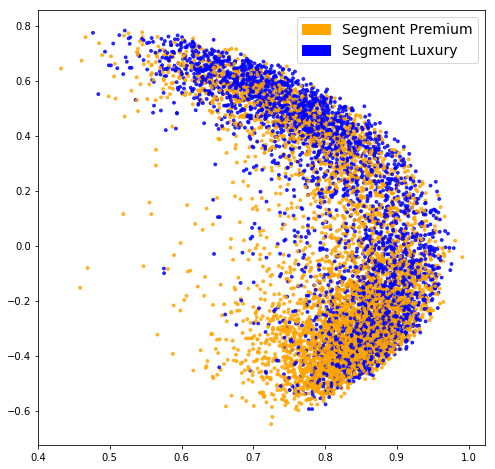

In [76]:
# TOPIC MODELING Word2Vec
fig = plt.figure(figsize=(8, 8))          
plot_LSA(X_word_average, y)
plt.show()

#### Analysis:
More yellow towards lower y-axis and mid x-axis.    
More blue towards lower x-axis and higher y-axis.  

In [77]:
# Number of topics.
ntopics=2

# Number of words to look at for each topic.
n_top_words = 20

In [78]:
# LSA
svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
wine_lsa = lsa.fit_transform(tfidf_ngram)

lsa_components = word_topic(tfidf_ngram, wine_lsa, tfidf_ngram_feat)

topwords=pd.DataFrame()
topwords['LSA']=top_words(lsa_components, n_top_words)  

In [79]:
# LDA
lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

lda_wine = lda.fit_transform(tfidf_ngram) 
lda_components = word_topic(tfidf_ngram, lda_wine, tfidf_ngram_feat)
topwords['LDA']=top_words(lda_components, n_top_words)

In [80]:
# NNMF
nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
nmf_wine = nmf.fit_transform(tfidf_ngram) 

nmf_components = word_topic(tfidf_ngram, nmf_wine, tfidf_ngram_feat)

topwords['NNMF']=top_words(nmf_components, n_top_words)

In [81]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic][0:40])

Topic 0:
              LSA              LDA            NNMF
0  rich 420.49     silki 321.6      rich 25.96    
0  silki 379.54    rich 258.85      tannin 25.0   
0  tannin 376.76   tannin 238.52    finish 24.48  
0  ripe 362.68     ripe 223.71      ripe 23.2     
0  finish 362.6    sweet 212.39     bodi 22.48    
0  complex 332.21  good 211.97      soft 16.66    
0  textur 330.12   complex 204.74   complex 16.64 
0  sweet 311.29    textur 204.0     sweet 15.97   
0  bodi 309.64     eleg 184.26      earthi 14.73  
0  soft 298.33     crisp 180.75     textur 13.94  
0  good 267.72     finish 175.03    balanc 13.49  
0  tart 255.99     tart 164.09      tart 12.96    
0  eleg 250.02     delici 156.0     delici 11.24  
0  crisp 232.55    bodi 150.52      structur 11.12
0  balanc 225.47   soft 147.84      fresh 10.86   
0  delici 225.14   fine 146.57      silki 10.44   
0  earthi 217.85   balanc 141.08    layer 9.32    
0  structur 196.4  nice 130.25      eleg 9.32     
0  fine 192.48     str

#### Doesn't appear to have significant cluster difference between cluser 0 and 1.  Topic 0 appears to be luxury, and topic 1 appears to be premium.

## Step 5: Text Classification with Logistic Regression, Random Forest and SVM

30 PCA components to explain 80%
Using price, description length, regions, and TD-IDF scores

In [82]:
df_pn20_prc.iloc[:,30:40].columns

Index(['region_1_Santa Lucia Highlands', 'region_1_Santa Maria Valley',
       'region_1_Sonoma Coast', 'region_1_Sonoma County',
       'region_1_Sta. Rita Hills', 'point_rank', 'prc_bc', 'desc_len_bc',
       'clean_desc', 'age'],
      dtype='object')

In [83]:
X = df_pn20_prc.iloc[:,16:].drop(columns=['clean_desc', 'point_rank'], axis=1)
y = df_pn20_prc['point_rank']

In [84]:
# SET PCA ABOVE 80% VARIANCE EXPLAINED, HOWEVER MANY COMPONENTS
selector = PCA(n_components=.80).fit(X,y)

# SELECT # COMPONENTS
#selector = PCA(n_components=10).fit(X,y)
var_explained = selector.explained_variance_ratio_ 
var_explained = pd.Series(var_explained)
#print(round(var_explained,4)) 

In [85]:
pca = PCA(n_components = 30)
logreg = LogisticRegression(solver='lbfgs',max_iter=50000)
pipeline = Pipeline([('pca', pca), ('logistic', logreg)])
score_fs_pca = cross_val_score(pipeline, X, y, scoring="accuracy", cv=3)   
print("mean={:.2f}   std=(+/- {:.2f})   all={} ".format(score_fs_pca.mean(),
                                                        score_fs_pca.std()*2, score_fs_pca))

mean=0.81   std=(+/- 0.03)   all=[0.81804568 0.82066642 0.78397604] 


### Logistic Regresion

In [86]:
pca = PCA(n_components = 30)
clf_lr = LogisticRegression(solver='newton-cg',max_iter=50000)
pipeline = Pipeline([('pca', pca), ('logistic', logreg)])

#search_grid = { 
#    'solver': ['liblinear', 'newton-cg', 'saga','lbfgs'],
#    'C': [.001,.01,0.1,1,10,100,1000]
#}

# LESS THAN ONE MINUTE TO RUN
# IDENTIFY BEST PARAMETERS WITH GridSearchCV
search_grid = { 
    'solver': ['newton-cg'],
    'C': [1]
}

clf_lr_cv_pca = GridSearchCV(estimator=clf_lr, param_grid=search_grid, cv=3, scoring='accuracy')
clf_lr_cv_pca.fit(X, y);

In [87]:
print("LR Accuracy Best Paramaters GridSearchCV:")
print("Principal Component Analysis:\t{:.3f}".format(clf_lr_cv_pca.best_score_))
print()
print("Best Paramaters GridSearchCV:")
print("PCA:{}".format(clf_lr_cv_pca.best_params_))

LR Accuracy Best Paramaters GridSearchCV:
Principal Component Analysis:	0.823

Best Paramaters GridSearchCV:
PCA:{'C': 1, 'solver': 'newton-cg'}


### Random Forest Classifier

In [88]:
start_time = time.time()
print("Start Time: {}".format(time.ctime()))

pca = PCA(n_components = 30)
clf_rfc = ensemble.RandomForestClassifier(criterion='gini', n_estimators=2000, max_features='sqrt',
                                          max_depth=4, n_jobs=-1) 
clf_rfc = Pipeline([('pca', pca), ('clf', clf_rfc)])

# 7 MINUTES TO RUN
#parameter_candidates = { 
#    'clf__n_estimators': [1000,2000],
#    'clf__max_features': ['sqrt','log2'],
#    'clf__criterion': ['gini'],
#    'clf__max_depth': [2,3,4],
#    'pca__n_components': [90]
#}

# X MINUTES TO RUN
parameter_candidates = { 
    'clf__criterion': ['gini'],
    'clf__n_estimators': [2000],
    'clf__max_features': ['sqrt'],
    'clf__max_depth': [4],
    'pca__n_components': [10]
}

clf_rfc_cv_pca = GridSearchCV(estimator=clf_rfc, param_grid=parameter_candidates, cv=3, 
                              scoring='accuracy')
clf_rfc_cv_pca.fit(X, y)
#print(clf_lr.get_params().keys())

print("Elapsed Time:")
print("--- {:.2f} seconds ---".format(time.time() - start_time))
print("--- {:.2f} minutes ---".format((time.time() - start_time)/60))

Start Time: Wed Mar 11 19:34:37 2020
Elapsed Time:
--- 41.29 seconds ---
--- 0.69 minutes ---


In [89]:
print("RFC Accuracy Best Paramaters GridSearchCV:")
print("Principal Component Analysis:\t{:.3f}".format(clf_rfc_cv_pca.best_score_))
print()
print("Best Paramaters GridSearchCV:")
print("PCA:{}".format(clf_rfc_cv_pca.best_params_))

RFC Accuracy Best Paramaters GridSearchCV:
Principal Component Analysis:	0.797

Best Paramaters GridSearchCV:
PCA:{'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__max_features': 'sqrt', 'clf__n_estimators': 2000, 'pca__n_components': 10}


Accuracy Best Paramaters GridSearchCV:  
Principal Component Analysis:	0.795   

Best Paramaters GridSearchCV:  
PCA:{'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__max_features': 'sqrt',   'clf__n_estimators': 2000, 'pca__n_components': 90}  

### Support Vector Machine

In [90]:
start_time = time.time()
print("Start Time: {}".format(time.ctime()))

pca = PCA(n_components = 30)
clf_svc = SVC(C=10, kernel='linear')
clf_svc = Pipeline([('pca', pca), ('logistic', clf_svc)])

# SHORT TIME TO RUN, FEW MIN
parameter_candidates = [
  {'logistic__C': [10], 'logistic__kernel': ['linear']},
]

# 2 MINUTES TO RUN
#parameter_candidates = [
#  {'logistic__C': [.01, 1, 10], 'logistic__kernel': ['linear']},
#  {'logistic__C': [.01, 1, 10], 'logistic__gamma': [0.001, 0.0001], 
#   'logistic__kernel': ['rbf'], 'pca__n_components': [90]},
#]

# CREATE CLASSIFIER OBJECT AND SEARCH FOR BEST PARAMATER SETTINGS WITH GridSearchCV
clf_svc_cv_pca = GridSearchCV(estimator=clf_svc, param_grid=parameter_candidates, cv=3, 
                              scoring='accuracy')
clf_svc_cv_pca.fit(X, y);

print("Elapsed Time:")
print("--- {:.2f} seconds ---".format(time.time() - start_time))
print("--- {:.2f} minutes ---".format((time.time() - start_time)/60))

Start Time: Wed Mar 11 19:35:18 2020
Elapsed Time:
--- 10.40 seconds ---
--- 0.17 minutes ---


In [91]:
print("SVM Accuracy Best Paramaters GridSearchCV:")
print("Principal Component Analysis:\t{:.3f}".format(clf_svc_cv_pca.best_score_))
print()
print("Best Paramaters GridSearchCV:")
print("PCA:{}".format(clf_svc_cv_pca.best_params_))

SVM Accuracy Best Paramaters GridSearchCV:
Principal Component Analysis:	0.805

Best Paramaters GridSearchCV:
PCA:{'logistic__C': 10, 'logistic__kernel': 'linear'}


### Classification Model Performance

### All features, TF-IDF, regions, price, description length
>Logistic Regression
LR Accuracy Best Paramaters GridSearchCV:
Principal Component Analysis: 0.82

>Random Forest
RFC Accuracy Best Paramaters GridSearchCV:
Principal Component Analysis: 0.80

>Support Vector Machine
SVM Accuracy Best Paramaters GridSearchCV:
Principal Component Analysis:	0.81


### Benchmarking for reference

>Price and description length: 80%  
mean=0.80   std=(+/- 0.02)   all=[0.80456758 0.80643954 0.77948334]    

>Regions: 61%  
mean=0.61   std=(+/- 0.03)   all=[0.58554848 0.60913516 0.62560839]  

>Price, description length and regions: 80%  
mean=0.80   std=(+/- 0.03)   all=[0.80718832 0.81505054 0.7768626 ]  

>TF-IDF - PCA (80% = 90 PCs)  
mean=0.72   std=(+/- 0.07)   all=[0.72706851 0.75627106 0.67465369]  

>Word2Vec - PCA (80% = 5 PCs)  
mean=0.74   std=(+/- 0.08)   all=[0.75589667 0.78921752 0.68813179] 

#### CONFUSION MATRIX 
Null hypothesis: Not different (predict class 0 ... is same or different)x-axis predicted, y-axis actual.  
y-axis, no diff on top, diff below  
x-axis, no diff to left, diff to right  

Confusion matrix  
TP  FP    
FN  TN  

Type I (FP) errors. False Alarm. Actual satisfies the null hypothesis but the test rejects the null hypothesis. 
Type II (FN) errors. Actual does not satisfy the null hypothesis but the test accepts the null hypothesis.

Recall = TP / (TP + FN)  
Precision = TP / (TP + FP)  
accuracy = 0.8291, precision = 0.8290, recall = 0.8291, f1 = 0.8290
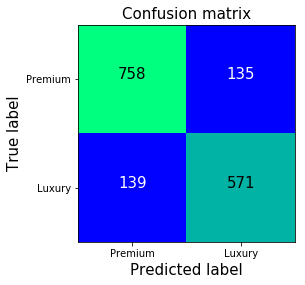

In [92]:
#https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=15)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=15)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)

    return plt

In [93]:
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [94]:
X = df_pn20_prc.iloc[:,16:].drop(columns=['clean_desc','point_rank'], axis=1)
y = df_pn20_prc['point_rank']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [95]:
clf_tfidf = LogisticRegression(solver='lbfgs',max_iter=50000, random_state=42)
clf_tfidf.fit(X_train, y_train)
y_predicted_tfidf = clf_tfidf.predict(X_test)

In [96]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, 
                                                                      y_predicted_tfidf)
print("accuracy = %.4f, precision = %.4f, recall = %.4f, f1 = %.4f" % (accuracy_tfidf, 
                                                                       precision_tfidf, 
                                                                       recall_tfidf, 
                                                                       f1_tfidf))

accuracy = 0.8291, precision = 0.8290, recall = 0.8291, f1 = 0.8290


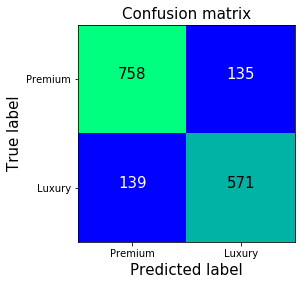

Null hypothesis: Not different (premium, class 0 is same as luxury, class1)
x-axis predicted, y-axis actual

Confusion Matrix 
TP FP
FN TN

Recall = TP / (TP + FN)
Precision = TP / (TP + FP)

accuracy = 0.8291, precision = 0.8290, recall = 0.8291, f1 = 0.8290
Type I (FP) errors. False Alarm. Actual satisfies the null hypothesis but the test rejects the null hypothesis.
Type II (FN) errors. Actual does not satisfy the null hypothesis but the test accepts the null hypothesis.


In [97]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(4, 4))
# CAN HAVE MULTIPLE CLASSES
plot = plot_confusion_matrix(cm2, classes=['Premium','Luxury'], normalize=False, 
                             title='Confusion matrix')
plt.show()
#print("TF-IDF confusion matrix")
#print(cm2)
print("Null hypothesis: Not different (premium, class 0 is same as luxury, class1)")
print("x-axis predicted, y-axis actual")
print()
print("Confusion Matrix ")
print("TP FP")
print("FN TN")
print()
print("Recall = TP / (TP + FN)" )
print("Precision = TP / (TP + FP)")
print()
print("accuracy = %.4f, precision = %.4f, recall = %.4f, f1 = %.4f" % (accuracy_tfidf, 
                                                                       precision_tfidf, 
                                                                       recall_tfidf, 
                                                                       f1_tfidf))
print("Type I (FP) errors. False Alarm. Actual satisfies the null hypothesis but the test rejects the null hypothesis.")

print("Type II (FN) errors. Actual does not satisfy the null hypothesis but the test accepts the null hypothesis.")

#### It appears Logistic Regression has best accuracy score when for classifying the target variable. Precision and recall are balanced. Type I and Type II errors are balanced. 

## Step 6: Application for Generation Z

App will have inputs from user, such as variety (ex. pinot noir), winery (ex. Peay Vineyards), region (ex. Sonoma Coast), country (ex. US) characteristics of wine they prefer (ex. minerality, medium acid, complex, integrated, long length, floral), price (ex. <40), segment (ex. Luxury), point rating min (ex. >=90), or perceived rating through text analysis (ex. Luxury). 

Can take inputs and filter the input dataframe and results using TF-IDF. See example below.

For example, select for pinot noir, and ask the app for suggestions of other pinot noir wines that are 90 points or greater, and produced in the US.The app will "train" the dataset by marking all pinot noir reviews 96 points or greater as wines the user likes. Note, diff than minimum of 90 for suggestion. Can also add filters such as price, for example, less than $40.

Can also look for similar varietals in similar regions with similar ratings, or even have different varietals in diff regions with smilar ratings, but diff varietal or same varietal.

In [98]:
wine_var_list = ['Syrah', 'Zinfandel']
df_wine = df.copy()
df_wine = df_wine[(df_wine['points'] >=90) &
                  (df_wine['country'] == 'US') &
                  (df_wine['variety'].isin(wine_var_list))]
df_wine.shape

(3307, 13)

In [99]:
df_wine['points'].value_counts()

90     946
91     813
92     703
93     469
94     249
95     71 
96     28 
97     13 
98     8  
99     4  
100    3  
Name: points, dtype: int64

In [100]:
# MARK REVIEWS AS THOSE PREFERRED BY USER, AND TO USE FOR SIMILARITY SCORE
df_wine['user_pref'] = df_wine[df_wine['variety'].isin(wine_var_list)]['points'].apply(lambda x: 1 if x >=96 else 0)

In [101]:
# TF-IDF MODEL
#tf = TfidfVectorizer(analyzer='word',
#                     min_df=.1,
#                     stop_words='english')

tf = TfidfVectorizer(
    #max_df=0.1,  # above max ignore word
    min_df=0.01,  # below min ignore word
    analyzer='word', 
    token_pattern=r'\w{1,}', 
    ngram_range=(1,1), 
    max_features=5000,
    #stop_words='english', 
    stop_words=stopwords, 
    lowercase=False,
    vocabulary=None)

In [102]:
# TRANSFORM DATA USING TF-IDF MODEL
tfidf_matrix = tf.fit_transform(df_wine['description'])

C:\Users\DJ\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['Valley', 'grande'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [103]:
# COMPUTE COSINE SIMILARITIES IN tfidf_matrix
cosine_similarities = cosine_similarity(tfidf_matrix,tfidf_matrix)

In [104]:
# RESET INDEX SO CAN ITERATE
user_pref_idx = df_wine[df_wine['user_pref'] == 1].reset_index()

In [105]:
# INITIALIZE DICTIONARY
results = {} 

# ITTERATE THROUGH USER PREFERENCE ROWS
for idx, row in user_pref_idx.iterrows():
    # GET TOP FIVE FOR EACH REVIEW ROW MARKED AS LIKED AND A USER_PREF
    similar_indices = cosine_similarities[idx].argsort()[:-5:-1] 
    # FIND TF-IDF SCORE
    similar_items = [(cosine_similarities[idx][i], 
                      df.reset_index()['index'][i]) for i in similar_indices] 
    # APPEND ALL TO DICTIONARY, EXCEPT SELF, THE FIRST OBSERVATION
    results[row['index']] = similar_items[1:]

In [106]:
tfidf_recs = pd.DataFrame()

# PROCESS DICTIONARY AND ADD TO DATAFRAME
for k, v in results.items():
    for i in v:
        tfidf_recs = tfidf_recs.append(df_wine[df_wine.index.isin([i[1]])])    

In [107]:
# OUTPUT RESULTS
tfidf_recs[tfidf_recs['price'] < 40].drop(columns='description')

,country,designation,points,price,province,region_1,region_2,variety,winery,taster_name,taster_twitter_handle,title,user_pref
207,US,Home Ranch Teldeschi Vineyards Century Old Vine,90,32.0,California,Dry Creek Valley,Sonoma,Zinfandel,Del Carlo Winery,Virginie Boone,@vboone,Del Carlo Winery 2014 Home Ranch Teldeschi Vineyards Century Old Vine Zinfandel (Dry Creek Valley),0
2898,US,Flight,91,38.0,California,Dry Creek Valley,Sonoma,Zinfandel,Quivira,NaN,NaN,NaN,0
1885,US,Old Vine,91,30.0,California,Dry Creek Valley,Sonoma,Zinfandel,Dry Creek Vineyard,NaN,NaN,NaN,0
2332,US,Estate Vineyards,90,36.0,California,Napa Valley,Napa,Syrah,Burgess,NaN,NaN,NaN,0
2227,US,Sherman Family Vineyard Old Vine,90,24.0,California,Lodi,Central Valley,Zinfandel,Fields Family,NaN,NaN,NaN,0
65,US,Estate Select,91,36.0,California,Santa Clara Valley,Central Coast,Syrah,Jason-Stephens,NaN,NaN,NaN,0


## Step 7: Summary

#### Q: Why I chose this project.     
This project is an exploration f the NLP specialization. The project covers many of the common and advanced NLP uses and extends it to cosine similarities and recommendation. I wanted to stretch myself and do an in-depth review of NLP.

#### Q: Why it works.  
The TF-IDF recommendation engine can be extended to perform a number of tasks for a number of users types, meaning both supply and demand side of the wine industry.  

#### Q: What problem is solved.  
Education and suggestions to those overwhelmed by choosing a wine and whom prefer an app based interface. Business side can also utilize this type of tool to perform basic segmentation analysis as well as pricing research.   

#### Q: How it will run in a production like environment.   
This type of model will be an ensemble model. As wine differs from region to region, and variety to variety, so will the reviews. Best to compare apples to apples and create a collection of ensemble models specializing in topic areas. There will be a GUI for this application so users can easily select preferences and filters, as well as have a nice presentation of information. 

#### Q: What would you need to do to maintain it going forward?  
As years come and go, collect reviews, update the dataset, and retrain the models and stopwords on the new data.

#### Q: A specified research question your model addresses.
Project educates and recommends product to the consumer.

#### Q: How you chose your model specification and what alternatives you compared it to.  
Chose model based on benchmarking and comparing different scores like Word2Vec and TF-IDF. Also compared different clustering methods, topic modeling methods, and different classification algorithms for predicting class. 

#### Q: Quantifiable results based on the research you’ve conducted.  
Prediction is balaced between recall and precision. Accuracy is in the low 80%. Logistic Regression scored highest, followed by SVM and then Random Forest. TF-IDF performs better than Word2Vec.

#### Q: The visuals you chose and what they represent for your research.  
Used scatter, boxplot, histogram, and bar to visualize density, variance, outliers, and trend in data. 


#### Your end-user and the value your project provides to them.  
End user is Generation Z or any group interested in wine and looking for suggestion of varietals, wines, or valuation relative to others in a region, rating class, or price point.   

#### The practical uses of your model for an audience of interest.  
Identify quality wine at a reasonable price. Get suggestion for unique varietals from different regions or countries. Determine if wine is over rated/underrated, overvalued/undervalued.

#### Potential problems, weak points or shortcomings of your model.  
* Availiability of reviews: Ideally would have a list of all wineries and retail pricing with accurate descriptions, meaning descriptions that have structure and are similar.
* Comparability: Descriptions are not structured, and the high end wines get a more complete review. Doesn't lend to comparison. For example, a review should likly speak to alcohol levels, structure, complexity, body, length, smell, and flavor characteristics including varietal specific, region specific, barrel influence, and secondary as well as terciary characteristics.  
* Taste and valued features of wine are subjective.  
* Stopwords, or words of little value with respect to wine reviews are more nuanced and need consideration to have quality generalized performance.  Consider using preset vocabulary versus training and scoring a vocabulary.
* Word averaging with Word2Vec doesn't seem to be the best approach for similar document analysis.  

#### Bias
> Selection Bias:  
* High rating/price. Wine enthusiast targeting higher end wines, which generally have higher ratings and price. 
* Regions. The regions of US, California, and varietal of Pinot Noir receive the most reviews. Note there is a bias in this dataset to Russian River Valley and the Sonoma Coast as they are have significantly more reviews than the majority of other regions.  This should not impact project and is more a statement on the primary regions for Premium and Luxury pinot noir production.  
* Sentiment: Reviews are more positive or neutral as oppessed to negative. Believe this is due to industry influence and target market, as well as selection. 


#### Additional research proposal  
* Take an ensemble approach. Train a series of models based on variety and region so can have accurate, apples-to-apples NLP text processing.  
* Develop the application to do business side segmentation.  Know if undervalued or overvalued for region and varietal.  
* Compute life time value of customer.
* Use demographic data to segment data.  
* Use PLSA for topic modeling. More appropriate given example at end and how approaching.  
* Dictionary documents specific to desired topics using vocabulary in TF-IDF. 
* Use Word2Vec without word averaging.